In [1]:
import os
import re
import csv
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from collections import Counter
from scipy.stats import shapiro
from sklearn import preprocessing
from matplotlib import pyplot as plt
import statsmodels.stats.multitest as smm
from statistics import mean, variance, median
from sklearn.feature_extraction.text import TfidfVectorizer


# Abstract Fixation Counts and Durations

# Take 3

In [2]:
with open("midprocessing/reading_scanpaths.pkl", "rb") as f:
    rscan_paths = pickle.load(f)
with open("midprocessing/writing_scanpaths.pkl", "rb") as f:
    wscan_paths = pickle.load(f)
with open("midprocessing/participant_scanpaths.pkl", "rb") as f:
    participant_scanpaths = pickle.load(f)
with open("midprocessing/reading_functions.pkl", "rb") as f:
    reading_functions = pickle.load(f)
with open("midprocessing/writing_functions.pkl", "rb") as f:
    writing_functions = pickle.load(f)
with open("midprocessing/abstract_code_parts.pkl", "rb") as f:
    abstract_code_parts = pickle.load(f)
    
fix_rfiles = os.listdir("abstract_fixation_counts/reading")
fix_wfiles = os.listdir("abstract_fixation_counts/writing")
dur_rfiles = os.listdir("abstract_fixation_durations/reading")
dur_wfiles = os.listdir("abstract_fixation_durations/writing")


In [8]:
unique = set()
for k, v in abstract_code_parts.items():
    for kk, vv in v.items():
        try:
            unique.add(vv[0])
        except:
            x=5
print(len(unique), unique)

19 {'parameter', 'operator', 'assignment', 'operation', 'variable', 'external class', 'comment', 'function call', 'conditional statement', 'argument', 'exception handling', 'loop', 'function declaration', 'variable declaration', 'return', 'conditional block', 'index operation', 'literal', 'externally defined variable or function'}


In [1]:
# def filter_by_precedence(array):
#     precedence = ['function declaration', 'parameter', 'return', 'conditional statement', 'exception handling',
#                   'loop', 'conditional block', 'variable declaration', 'argument', 'variable', 'function call',
#                   'external class', 'externally defined variable or function', 'operation', 'assignment']
#     for category in precedence:
#         if category in array:
#             return category
#     # return array

# # if a list has loop and conditional statement, 'loop conditional statement'
# # if it has loop but not conditional statement, it's loop body
# for function, tokens in abstract_code_parts.items():
#     for token, code_parts in tokens.items():
#         if len(code_parts) > 1:
#             presiding = filter_by_precedence(code_parts)
#             abstract_code_parts[function][token] = [presiding]


# with open("midprocessing/abstract_code_parts_by_precedence.pkl", 'wb') as f:
#     pickle.dump(abstract_code_parts, f)        


In [33]:
important_features = ['variable declaration', 'function declaration', 'parameter', 'argument',
                      'conditional statement', 'function call']  # , 'loop' , 'conditional block'

def abstract_scanpaths(scanpaths, abstract_parts):
    functions_as_documents = []
    for func in scanpaths:
        new_path = ''
        curr = abstract_parts[func]
        for path in scanpaths[func]:  
            for token in path:
                try:
                    abstract = curr[token]
                    abstract = [re.sub(" ", "_", abstract[i]) for i, el in enumerate(abstract)]
                    new_path += str(" ".join(abstract) + " ")
                except:
                    print(f"Key Error on {token} in {func}") 
        functions_as_documents.append(new_path)
    return functions_as_documents
    
def normalize(lst, min_val, max_val):
    return [(x - min_val) / (max_val - min_val) for x in lst]


def cohens_d(list1, list2):
    n1, n2 = len(list1), len(list2)
    s1, s2 = np.nanvar(list1, ddof=1), np.nanvar(list2, ddof=1)
    pooled_var = ((n1-1) * s1 + (n2-1) * s2) / (n1 + n2 - 2)
    return (np.nanmean(list1) - np.nanmean(list2)) / np.sqrt(pooled_var)


def check_columns(columns):
    all_present = True
    for item in important_features:
        if item not in columns:
            # print(item)
            all_present = False
    return all_present

def decide_t_test(g1_data, g2_data): # based on variance, decide which t-test to use
    g1var = np.nanvar(g1_data, ddof=1)
    g2var = np.nanvar(g2_data, ddof=1)
    larger = max(g1var, g2var)
    smaller = min(g1var, g2var)
    ratio = larger/smaller
    # test = "Student's" # only using Welch's so t-values can be compared
    # equal_var = True
    # if ratio >= 4:
    #     test = "Welch's"
    equal_var = False
    return "Welch's", equal_var
    

def my_t_test(name1, name2, df1, df2, filename):
    scanpath_pvals = []
    features = []
    output = {'abstract token': [], 
              'test used': [], 
              f"{name1} avg": [], 
              f"{name2} avg": [],
              't-value': [], 
              'p-value': [], 
              'effect size': []
    }
 
    for key in df1.keys():
        if key in important_features:
            g1_data = df1[key]
            g2_data = df2[key]
            g1_data = np.array(g1_data)[~np.isnan(g1_data)]
            g2_data = np.array(g2_data)[~np.isnan(g2_data)]
            if len(g1_data) >= 2 and len(g2_data) >= 2:
                test, equal_var = decide_t_test(g1_data, g2_data)
                t, p = stats.ttest_ind(a=g1_data, b=g2_data, equal_var=equal_var)
                scanpath_pvals.append(p)
                d = cohens_d(g1_data, g2_data)
                features.append(key)
                
                # print(f"{key} | {test} | Group1: {mean(g1_data):.4f} | Group2: {mean(g2_data):.4f}| t-value: {t:.4f}, p-value:{p:.4f}, effect size:{d:.4f}")
                output['abstract token'].append(key)
                output['test used'].append(test)
                output[f"{name1} avg"].append(mean(g1_data))
                output[f"{name2} avg"].append(mean(g2_data))
                output['t-value'].append(t)
                output['p-value'].append(p)
                output['effect size'].append(d)
                
            else:
                print(f"not enough data points to calculate variance for {key}")
    output = pd.DataFrame.from_dict(output)
    _, corrected_pvals, _, _ = smm.multipletests(scanpath_pvals, alpha=0.05, method='fdr_bh')
    output['q'] = list(corrected_pvals)
    output.to_csv(filename, index=False)
    return scanpath_pvals, features
 

def remove_features(ddict):
    return {k: v for k, v in ddict.items() if k in important_features}

def make_dictionaries(ddict, df):
    df = df.iloc[:, 1:]
    for key in df.keys():
        if key in ddict:
            ddict[key].extend(df[key].tolist())
        else:
            ddict[key] = df[key].tolist()
    return ddict

def calculate_max_min(ddict):
    all_values = [val for sublist in ddict.values() for val in sublist]
    min_val = min(all_values)
    max_val = max(all_values)
    return min_val, max_val

def collect_fixations(filelist, task):
    count = 0
    fixdict = {}
    durdict = {}
    for file in filelist:
        # print(file)
        fdf = pd.read_csv(f"abstract_fixation_counts/{task}/{file}")
        ddf = pd.read_csv(f"abstract_fixation_durations/{task}/{file}")
        columns = list(fdf.columns)
        # print("columns", columns)
        all_present = check_columns(columns)
        if not all_present:
            continue
        count += 1
        
        fixdict = make_dictionaries(fixdict, fdf)
        durdict = make_dictionaries(durdict, ddf)
        # print("cond state", durdict['conditional statement'])
        
    data_points = 0
    for k, v in fixdict.items():
        data_points += len(v)
        
    print("num keys: ", len(fixdict.keys()), "amount of data: ", data_points*2) # times 2 because we have data points for fixation counts and fixationd durations
    print(f"num files for {task}: ", count)
    # print(fixdict)    
    fmin_val, fmax_val = calculate_max_min(fixdict)
    dmin_val, dmax_val = calculate_max_min(durdict)
    fixdict_filtered = {k: normalize(v, fmin_val, fmax_val) for k, v in fixdict.items()}
    durdict_filtered = {k: normalize(v, dmin_val, dmax_val) for k, v in durdict.items()}
    durdict = {k: list(durdict[k]) for k in durdict.keys()}
    return fixdict_filtered, durdict # durdict_filtered
    # avg_fixdict_filtered = fixdict_filtered.copy()
    # avg_durdict_filtered = durdict_filtered.copy()
    
    # for key in fixdict_filtered.keys():
    #     avg_fixdict_filtered[key] = sum(avg_fixdict_filtered[key])/count
    #     avg_durdict_filtered[key] = sum(avg_durdict_filtered[key])/count
    # print(avg_fixdict_filtered)
    # print(avg_durdict_filtered)

def nan_test(dictionary):
    all_values = [val for sublist in dictionary.values() for val in sublist]
    boolean = any(np.isnan(val) for val in all_values)
    print(boolean)
    count = 0
    for k, v in dictionary.items():
        if any(np.isnan(val) for val in v):
            print(count, k)
        count += 1
    return 


def get_experts(df, criteria):
    # experts_by_years = ['106', '133', '136', '143', '155', '166', '189', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319']
    # experts_by_java = ['106', '119', '122', '133', '143', '166', '176', '186', '189', '311', '313', '314', '315', '316', '318']
    experts_by_years = ['189', '310', '311', '312', '313', '315', '316', '318', '319']
    novices_by_years = ['111', '117', '129', '139', '147', '168', '176', '182', '186', '191']
    experts_by_java = ['122', '119', '314', '313', '316', '106', '166', '176', '318', '143', '311']
    ids = df['pid'].astype(str)
    if criteria == 'years':
        viplist = experts_by_years
    elif criteria == 'java':
        viplist = experts_by_java
    else:
        print("That's not a valid expertise type")
    
    exp_idx = list(np.where(ids.isin(viplist)))[0]
    nov_idx = list(np.where(ids.isin(novices_by_years)))[0] # deciding just to use years
    exp_df = df.iloc[exp_idx, :]
    nov_df = df.iloc[nov_idx, :]

    return exp_df, nov_df


def collect_expertise_fixations(filelist, task, criteria):
    count = 0
    exp_fixdict = {}
    nov_fixdict = {} 
    exp_durdict = {}
    nov_durdict = {}
    
    for file in filelist:
        fdf = pd.read_csv(f"abstract_fixation_counts/{task}/{file}")
        ddf = pd.read_csv(f"abstract_fixation_durations/{task}/{file}")
        columns = list(fdf.columns)
        all_present = check_columns(columns)
        if not all_present:
            continue
        count += 1
        
        exp_fdf, nov_fdf = get_experts(fdf, criteria)
        exp_ddf, nov_ddf = get_experts(ddf, criteria)
        if len(exp_fdf) > 0:
            exp_fixdict = make_dictionaries(exp_fixdict, exp_fdf)
        if len(nov_fdf) > 0:
            nov_fixdict = make_dictionaries(nov_fixdict, nov_fdf)
        if len(exp_ddf) > 0:
            exp_durdict = make_dictionaries(exp_durdict, exp_ddf)
        if len(nov_ddf) > 0:
            nov_durdict = make_dictionaries(nov_durdict, nov_ddf)

    data_points = 0
    for k, v in exp_fdf.items():
        data_points += len(v)
    for k, v in nov_fdf.items():
        data_points += len(v)

    # times 2 because we have data points for fixation counts and fixationd durations
    print("num keys: ", "amount of data: ", data_points*2)
    print(f"num files for {task}: ", count)
    # need to make sure min/max are calculated across all reading and all writing
    fe_min_val, fe_max_val = calculate_max_min(exp_fixdict) 
    fn_min_val, fn_max_val = calculate_max_min(nov_fixdict) 
    fmin_val = min(fe_min_val, fn_min_val)
    fmax_val = max(fe_max_val, fn_max_val)
    # print(f"\n\n{task} min for {criteria}", fe_min_val, fn_min_val, fmin_val)
    # print(f"{task} max for {criteria}", fe_max_val, fn_max_val, fmax_val)
    # dmin_val, dmax_val = calculate_max_min(durdict)
    
    exp_fixdict_norm = {k: normalize(v, fmin_val, fmax_val) for k, v in exp_fixdict.items()}
    nov_fixdict_norm = {k: normalize(v, fmin_val, fmax_val) for k, v in nov_fixdict.items()}
    exp_durdict = {k: list(exp_durdict[k]) for k in exp_durdict.keys()}
    nov_durdict = {k: list(nov_durdict[k]) for k in nov_durdict.keys()}
    # durdict_filtered = {k: normalize(v, dmin_val, dmax_val) for k, v in durdict.items()}
    return exp_fixdict_norm, nov_fixdict_norm, exp_durdict, nov_durdict  # durdict_filtered


In [4]:
abstract_reading_paths = abstract_scanpaths(rscan_paths, abstract_code_parts)
abstract_writing_paths = abstract_scanpaths(wscan_paths, abstract_code_parts)

In [5]:
reading_temp_parts = [tokens.split(' ') for tokens in abstract_reading_paths]
writing_temp_parts = [tokens.split(' ') for tokens in abstract_writing_paths]

code_part_counts = {}
for path in reading_temp_parts:
    for token in path:
        if token not in code_part_counts:
            code_part_counts[token] = 1
        else:
            code_part_counts[token] += 1
            
for path in writing_temp_parts:
    for token in path:
        if token not in code_part_counts:
            code_part_counts[token] = 1
        else:
            code_part_counts[token] += 1

# Counter(abstract_reading_paths)
# len(abstract_reading_paths)

In [6]:
reading_vectorizer = TfidfVectorizer(sublinear_tf=True)
writing_vectorizer = TfidfVectorizer(sublinear_tf=True)
Xr = reading_vectorizer.fit_transform(abstract_reading_paths)
Xw = writing_vectorizer.fit_transform(abstract_writing_paths)
# for i, el in enumerate(abstract_reading_paths):
#     print(i)

In [7]:
reading_features = reading_vectorizer.get_feature_names_out()
writing_features = writing_vectorizer.get_feature_names_out()

<function matplotlib.pyplot.show(close=None, block=None)>

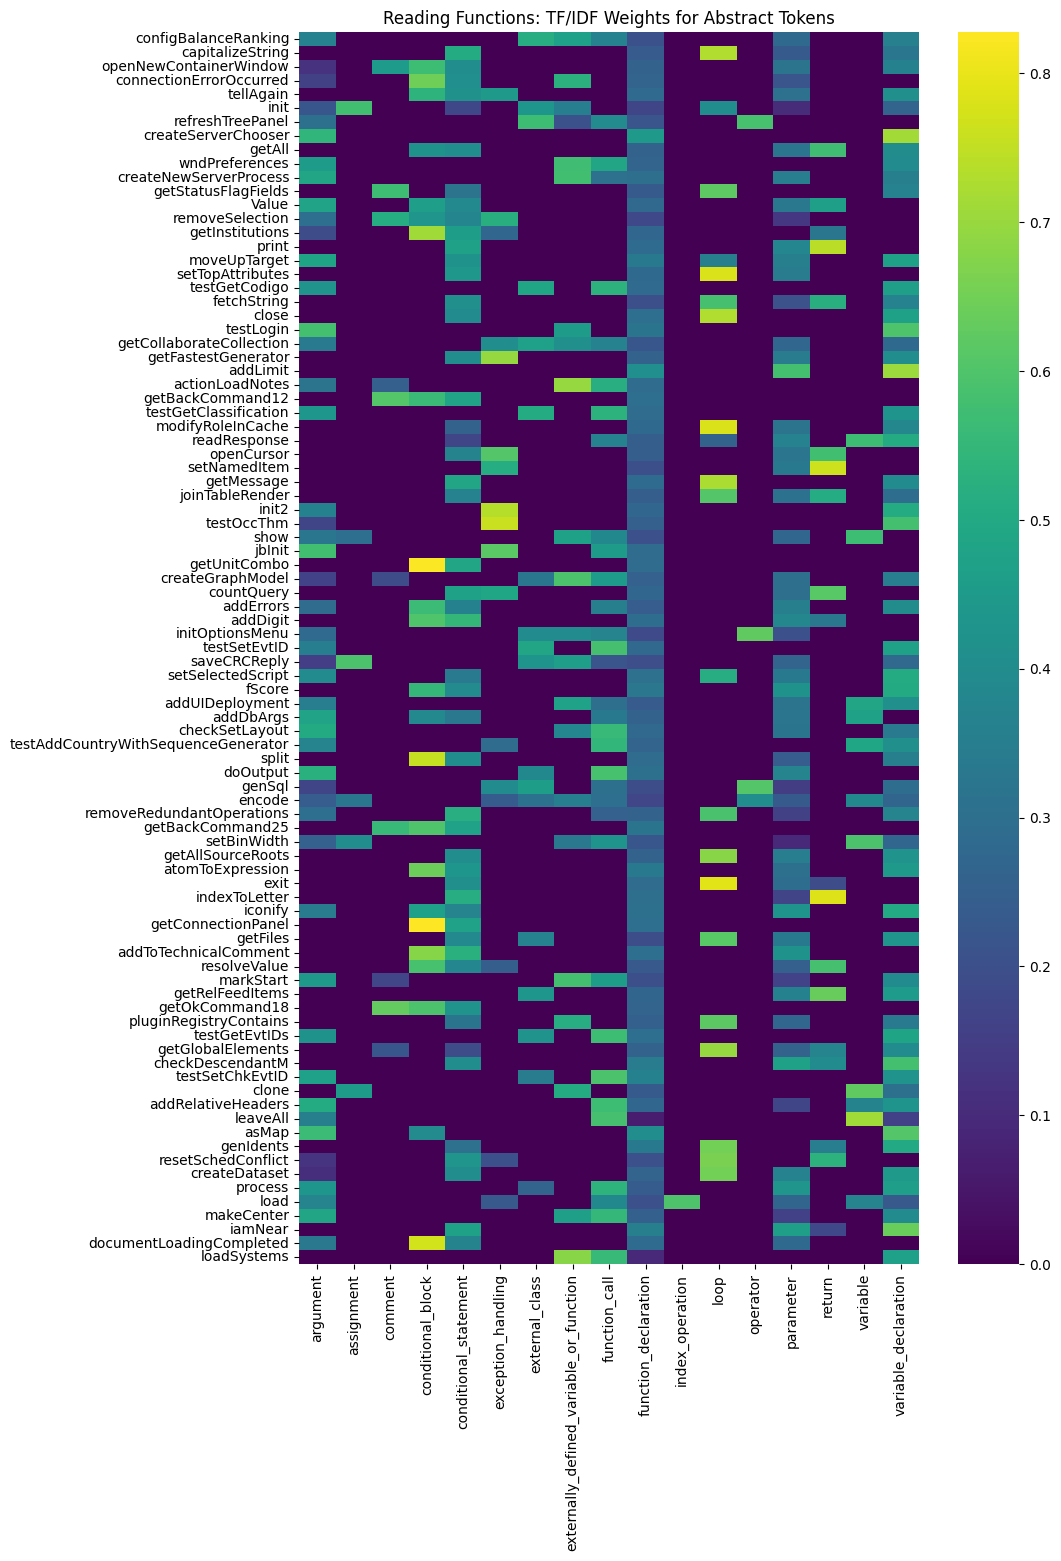

In [8]:
dfr = pd.DataFrame(Xr.toarray(), columns=reading_features, index=rscan_paths.keys())
plt.figure(figsize=(10,16))
sns.heatmap(dfr, xticklabels=True, yticklabels=True, cmap='viridis')
plt.title("Reading Functions: TF/IDF Weights for Abstract Tokens")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

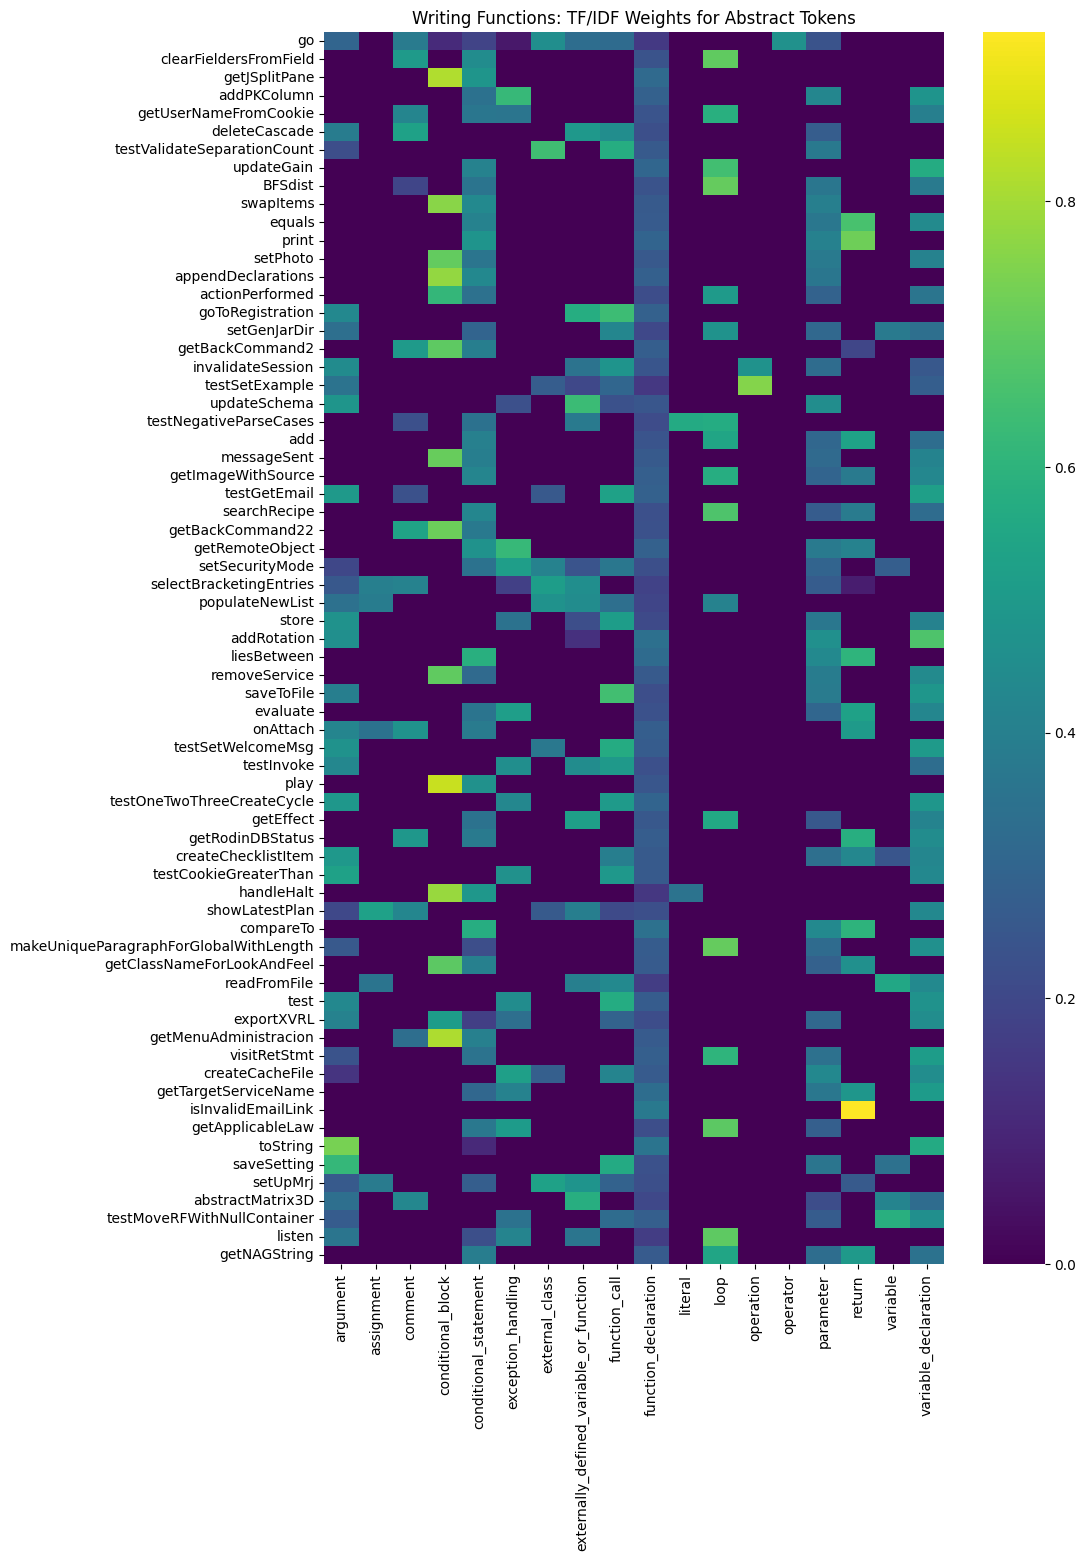

In [9]:
dfw = pd.DataFrame(Xw.toarray(), columns=writing_features, index=wscan_paths.keys())
plt.figure(figsize=(10, 16))
sns.heatmap(dfw, xticklabels=True, yticklabels=True, cmap='viridis')
plt.title("Writing Functions: TF/IDF Weights for Abstract Tokens")
plt.show


In [10]:
# average weights by column
Xr_avg = [mean(dfr.loc[:, col]) for col in dfr.columns]
Xw_avg = [mean(dfw.loc[:, col]) for col in dfw.columns]

# test if variance is equal 
Xr_var = variance(Xr_avg)
Xw_var = variance(Xw_avg)
larger = max(Xr_var, Xw_var)
smaller = min(Xr_var, Xw_var)
ratio = larger/smaller
#print(ratio) # the ratio isn't greater than 4, so variances can be considered equal

# test that data is normally distributed
print("reading weights", shapiro(Xr_avg))
print("writing weights", shapiro(Xw_avg))

# U test 
print("U-test:{}".format(stats.mannwhitneyu(Xr_avg, Xw_avg)))

reading weights ShapiroResult(statistic=0.9618290066719055, pvalue=0.6660777926445007)
writing weights ShapiroResult(statistic=0.9398177862167358, pvalue=0.2877119481563568)
U-test:MannwhitneyuResult(statistic=158.0, pvalue=0.8819307212779461)


### Fixation Count and Duration for top features

In [33]:
important = ['variable declaration', 'conditional statement', 'function declaration', 'conditional block' 'function call', 'loop']
rfeatures

{'variable_declaration': 0.27960961404022777,
 'function_declaration': 0.2585904821861907,
 'conditional_statement': 0.22537427289608336,
 'parameter': 0.19906931760691002,
 'function_call': 0.17837540394854928,
 'argument': 0.1618178060249193,
 'conditional_block': 0.15340170609885018,
 'loop': 0.14589051998212105,
 'variable': 0.13298186377829063,
 'externally_defined_variable_or_function': 0.11563630553735475,
 'return': 0.10555240120447168,
 'exception_handling': 0.08695069259903057,
 'external_class': 0.0841925964771247,
 'comment': 0.05125214186668718,
 'assignment': 0.031614704440509594,
 'operation': 0.030209206371471738,
 'operator': 0.02535095147222561,
 'index_operation': 0.006801235521390606,
 'literal': 0.002375010659384331}

In [45]:
# asdf = sorted(rfeatures.items(), key=lambda x:x[1], reverse=True)

In [13]:
code_part_counts = {}
for k, v in abstract_code_parts.items():
    for kk, vv in v.items():
        try:
            word = vv[0]
            if word in code_part_counts:
                code_part_counts[word] += 1
            else:
                code_part_counts[word] = 1
        except:
            x="hello"

In [32]:
np.corrcoef(list(code_part_counts.values()), list(rfeatures.values()))

array([[1.        , 0.53402961],
       [0.53402961, 1.        ]])

In [11]:
rfeatures = dict(zip(reading_features, Xr_avg))
rfeatures = {key: value for key, value in sorted(rfeatures.items(), key=lambda item: item[1], reverse=True)}

wfeatures = dict(zip(writing_features, Xw_avg))
wfeatures = {key: value for key, value in sorted(wfeatures.items(), key=lambda item: item[1], reverse=True)}

In [12]:
rfeatures

{'variable_declaration': 0.28683670593173805,
 'function_declaration': 0.2639024253959114,
 'conditional_statement': 0.22571261983472507,
 'parameter': 0.20148181649341307,
 'argument': 0.19551559998121049,
 'function_call': 0.16959059899300377,
 'conditional_block': 0.15249556065057762,
 'loop': 0.14660231977986113,
 'externally_defined_variable_or_function': 0.11768103654086985,
 'return': 0.10610611700920669,
 'exception_handling': 0.0860855263831976,
 'external_class': 0.08548291924258648,
 'variable': 0.06341758975206294,
 'comment': 0.046772746885599514,
 'assignment': 0.02977844605608598,
 'operator': 0.025013112627433425,
 'index_operation': 0.006691251897320905}

In [13]:
wfeatures

{'function_declaration': 0.2511903666597503,
 'variable_declaration': 0.24679458451243916,
 'conditional_statement': 0.23593632155053126,
 'parameter': 0.20499095363433323,
 'argument': 0.18617674967748246,
 'function_call': 0.167000245855373,
 'conditional_block': 0.15081984560457926,
 'loop': 0.1498987038661616,
 'return': 0.13573443221734732,
 'exception_handling': 0.11453753889911097,
 'externally_defined_variable_or_function': 0.11213444872490821,
 'comment': 0.08937774029029975,
 'external_class': 0.06551218419363754,
 'variable': 0.041131510400175986,
 'assignment': 0.035291533416307065,
 'operation': 0.018071417196916493,
 'literal': 0.013507636927088925,
 'operator': 0.006824679393637174}

In [21]:
top_wfeatures = [k for k, v in wfeatures.items() if v >= mean(list(wfeatures.values()))]
top_rfeatures = [k for k, v in rfeatures.items() if v >= mean(list(rfeatures.values()))]

feature_set = set(top_wfeatures + top_rfeatures)
print(len(feature_set), feature_set)

9 {'parameter', 'variable_declaration', 'function_declaration', 'conditional_statement', 'argument', 'return', 'function_call', 'conditional_block', 'loop'}


In [34]:
fix_rfiles = os.listdir("abstract_fixation_counts/reading")
fix_wfiles = os.listdir("abstract_fixation_counts/writing")
dur_rfiles = os.listdir("abstract_fixation_durations/reading")
dur_wfiles = os.listdir("abstract_fixation_durations/writing")

rfix_dict, rdur_dict = collect_fixations(fix_rfiles, 'reading')
wfix_dict, wdur_dict = collect_fixations(fix_wfiles, 'writing')
rfix_dict, rdur_dict = remove_features(rfix_dict), remove_features(rdur_dict)
wfix_dict, wdur_dict = remove_features(wfix_dict), remove_features(wdur_dict)

women = ['111', '117', '119', '129', '136', '166', '182', '317', '319']
reyf, rnyf, reyd, rnyd = collect_expertise_fixations(fix_rfiles, 'reading', 'years')
weyf, wnyf, weyd, wnyd = collect_expertise_fixations(fix_wfiles, 'writing', 'years')
# rejf, rnjf, rejd, rnjd = collect_expertise_fixations(fix_rfiles, 'reading', 'java')
# wejf, wnjf, wejd, wnjd = collect_expertise_fixations(fix_wfiles, 'writing', 'java')


num keys:  16 amount of data:  1660
num files for reading:  9
num keys:  11 amount of data:  1190
num files for writing:  6
num keys:  amount of data:  54
num files for reading:  9
num keys:  amount of data:  342
num files for writing:  6


In [35]:
# # # pure reading vs writing
# fixation_pvals, fix_features = my_t_test("reading", "writing", rfix_dict, wfix_dict, "stat_tests/reading_vs_writing_fc.csv")
# duration_pvals, dur_features = my_t_test("reading", "writing", rdur_dict, wdur_dict, "stat_tests/reading_vs_writing_fd.csv")

# # # reading vs writing with loops
# fixation_pvals, fix_features = my_t_test("reading", "writing", rfix_dict, wfix_dict, "stat_tests/loop_reading_vs_writing_fc.csv")
# duration_pvals, dur_features = my_t_test("reading", "writing", rdur_dict, wdur_dict, "stat_tests/loop_reading_vs_writing_fd.csv")

# reading vs writing with conditionals
fixation_pvals, fix_features = my_t_test("reading", "writing", rfix_dict, wfix_dict, "stat_tests/cond_reading_vs_writing_fc.csv")
duration_pvals, dur_features = my_t_test("reading", "writing", rdur_dict, wdur_dict, "stat_tests/cond_reading_vs_writing_fd.csv")

In [30]:
# # #### Without Loops or Conditionals
#TODO compare experts to novices on reading tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", reyf, rnyf, "stat_tests/reading_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", reyd, rnyd, "stat_tests/reading_experts_vs_novices_fd.csv")
# 
# TODO compare experts to novices on writing tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", weyf, wnyf, "stat_tests/writing_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", weyd, wnyd, "stat_tests/writing_experts_vs_novices_fd.csv")


In [33]:
#### With Loops
# # # TODO compare experts to novices on reading tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", reyf, rnyf, "stat_tests/loops_reading_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", reyd, rnyd, "stat_tests/loops_reading_experts_vs_novices_fd.csv")

# TODO compare experts to novices on writing tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", weyf, wnyf, "stat_tests/loops_writing_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", weyd, wnyd, "stat_tests/loops_writing_experts_vs_novices_fd.csv")


In [36]:
##### With Conditionals
#TODO compare experts to novices on reading tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", reyf, rnyf, "stat_tests/cond_reading_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", reyd, rnyd, "stat_tests/cond_reading_experts_vs_novices_fd.csv")

# TODO compare experts to novices on writing tasks for years of experience
fixation_pvals, fix_features = my_t_test("experts", "novices", weyf, wnyf, "stat_tests/cond_writing_experts_vs_novices_fc.csv")
duration_pvals, dur_features = my_t_test("experts", "novices", weyd, wnyd, "stat_tests/cond_writing_experts_vs_novices_fd.csv")


In [ ]:
# # TODO compare all reading with all writing in years of experience
# fexperts = {k: reyf[k] + weyf[k] for k, v in reyf.items() if k in weyf.keys()}
# fnovices = {k: rnyf[k] + wnyf[k] for k, v in rnyf.items() if k in wnyf.keys()}
# fixation_pvals, fix_features = my_t_test("experts", "novices", fexperts, fnovices)

# dexperts = {k: reyd[k] + weyd[k] for k, v in reyd.items() if k in weyd.keys()}
# dnovices = {k: rnyd[k] + wnyd[k] for k, v in rnyd.items() if k in wnyd.keys()}
# duration_pvals, dur_features = my_t_test("experts", "novices", dexperts, dnovices)


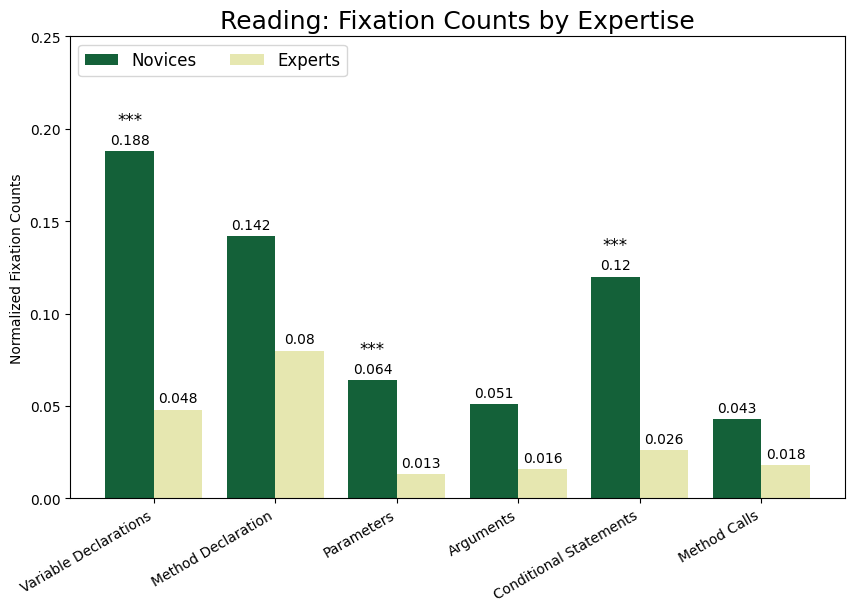

In [25]:
labels = ("Variable Declarations", "Method Declaration", 'Parameters', 'Arguments', 'Conditional Statements', 'Method Calls')
# need important_features, reyf, reyd, rnyf, rnyd
# weyf, weyd, wnyf, wnyd 
category_means = {
    'Novices': (mean(rnyf['variable declaration']), mean(rnyf['function declaration']), mean(rnyf['parameter']), 
                mean(rnyf['argument']), mean(rnyf['conditional statement']), mean(rnyf['function call'])),
    'Experts': (mean(reyf['variable declaration']), mean(reyf['function declaration']), mean(reyf['parameter']), 
                mean(reyf['argument']), mean(reyf['conditional statement']), mean(reyf['function call']))
}

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0
significance = [3, 0, 3, 0, 3, 0]
star_offset = 0.012
fig, ax = plt.subplots(figsize=(10, 6))  # layout='constrained')
colors = ['#146139ff',  '#e6e7b0ff']
i = 0
for attribute, measurement in category_means.items():
    offset = width * multiplier
    measurement = [round(num, 3) for num in measurement]
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[i])
    ax.bar_label(rects, padding=3)
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        if attribute == 'Novices' and significance[idx] > 0:
            ax.text(rect.get_x() + rect.get_width()/2., height + star_offset, '*'*significance[idx],
                    ha='center', va='bottom', color='black', fontsize=12)
    
    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Fixation Counts')
ax.set_title('Reading: Fixation Counts by Expertise', fontsize=18)
ax.set_xticks(x+0.5*width, labels)
plt.xticks(rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper left', ncols=3, fontsize=12)
ax.set_ylim(0, 0.25)
plt.savefig('plots/expertise_fixation_counts_reading.png', dpi=300, bbox_inches='tight')
plt.show()


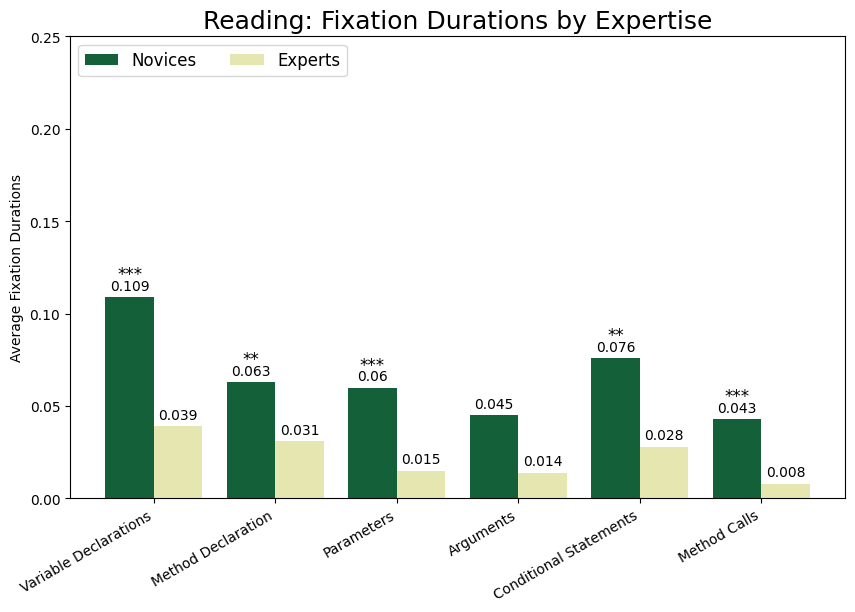

In [13]:
labels = ("Variable Declarations", "Method Declaration", 'Parameters',
          'Arguments', 'Conditional Statements', 'Method Calls')
# need important_features, reyf, reyd, rnyf, rnyd
# weyf, weyd, wnyf, wnyd
category_means = {
    'Novices': (mean(rnyd['variable declaration']), mean(rnyd['function declaration']), mean(rnyd['parameter']),
                mean(rnyd['argument']), mean(rnyd['conditional statement']), mean(rnyd['function call'])),
    'Experts': (mean(reyd['variable declaration']), mean(reyd['function declaration']), mean(reyd['parameter']),
                mean(reyd['argument']), mean(reyd['conditional statement']), mean(reyd['function call']))
}

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 6))  # layout='constrained')
significance = [3, 2, 3, 0, 2, 3] # based on the statistical tests in the ./stat_tests folder
star_offset = 0.0075
colors = ['#146139ff',  '#e6e7b0ff']
i = 0
for attribute, measurement in category_means.items():
    offset = width * multiplier
    measurement = [round(num, 3) for num in measurement]
    rects = ax.bar(x + offset, measurement, width,
                   label=attribute, color=colors[i])
    ax.bar_label(rects, padding=3)
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        if attribute == 'Novices' and significance[idx] > 0:
            ax.text(rect.get_x() + rect.get_width()/2., height + star_offset, '*'*significance[idx],
                    ha='center', va='bottom', color='black', fontsize=12)
    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Fixation Durations')
ax.set_title('Reading: Fixation Durations by Expertise', fontsize=18)
ax.set_xticks(x+0.5*width, labels)
plt.xticks(rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper left', ncols=3, fontsize=12)
ax.set_ylim(0, 0.25)
plt.savefig('plots/expertise_fixation_durations_reading.png', dpi=300, bbox_inches='tight')
plt.show()


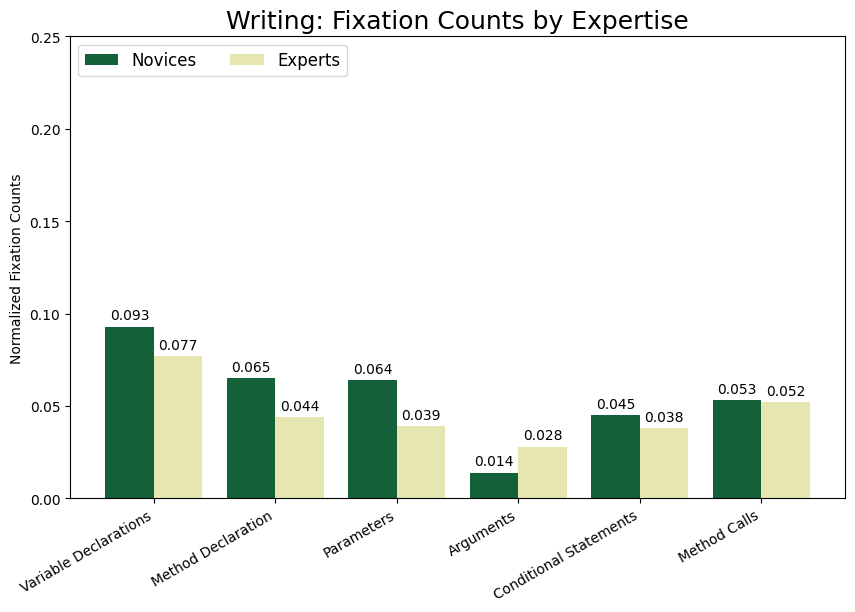

In [27]:
labels = ("Variable Declarations", "Method Declaration", 'Parameters',
          'Arguments', 'Conditional Statements', 'Method Calls')
# need important_features, reyf, reyd, rnyf, rnyd
# weyf, weyd, wnyf, wnyd
category_means = {
    'Novices': (mean(wnyf['variable declaration']), mean(wnyf['function declaration']), mean(wnyf['parameter']),
                mean(wnyf['argument']), mean(wnyf['conditional statement']), mean(wnyf['function call'])),
    'Experts': (mean(weyf['variable declaration']), mean(weyf['function declaration']), mean(weyf['parameter']),
                mean(weyf['argument']), mean(weyf['conditional statement']), mean(weyf['function call']))
}

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0
significance = [0, 0, 0, 0, 0, 0]
star_offset = 0.012
fig, ax = plt.subplots(figsize=(10, 6))  # layout='constrained')
colors = ['#146139ff',  '#e6e7b0ff']
i = 0
for attribute, measurement in category_means.items():
    offset = width * multiplier
    measurement = [round(num, 3) for num in measurement]
    rects = ax.bar(x + offset, measurement, width,
                   label=attribute, color=colors[i])
    ax.bar_label(rects, padding=3)
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        if attribute == 'Novices' and significance[idx] > 0:
            ax.text(rect.get_x() + rect.get_width()/2., height + star_offset, '*'*significance[idx],
                    ha='center', va='bottom', color='black', fontsize=12)

    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Fixation Counts')
ax.set_title('Writing: Fixation Counts by Expertise', fontsize=18)
ax.set_xticks(x+0.5*width, labels)
plt.xticks(rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper left', ncols=3, fontsize=12)
ax.set_ylim(0, 0.25)
plt.savefig('plots/expertise_fixation_counts_writing.png',
            dpi=300, bbox_inches='tight')
plt.show()


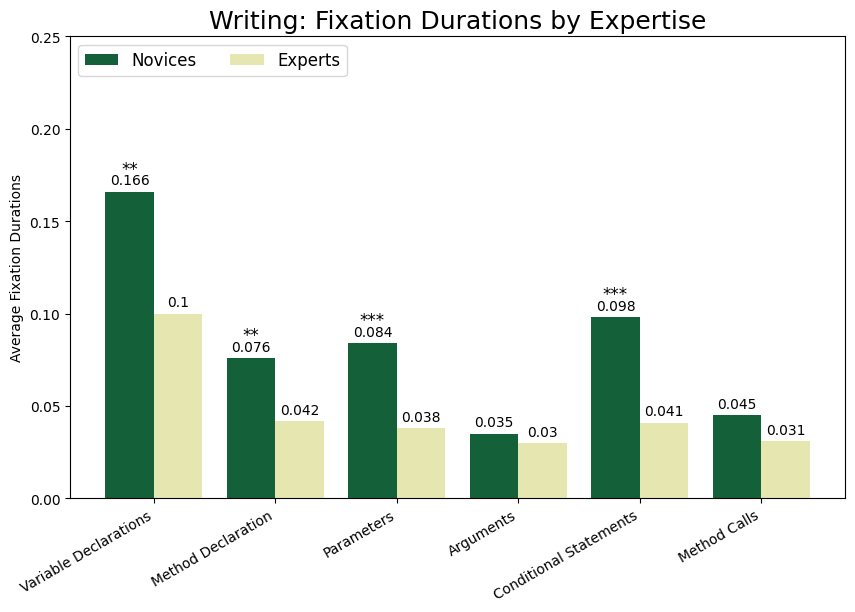

In [28]:
labels = ("Variable Declarations", "Method Declaration", 'Parameters',
          'Arguments', 'Conditional Statements', 'Method Calls')
# need important_features, reyf, reyd, rnyf, rnyd
# weyf, weyd, wnyf, wnyd
category_means = {
    'Novices': (mean(wnyd['variable declaration']), mean(wnyd['function declaration']), mean(wnyd['parameter']),
                mean(wnyd['argument']), mean(wnyd['conditional statement']), mean(wnyd['function call'])),
    'Experts': (mean(weyd['variable declaration']), mean(weyd['function declaration']), mean(weyd['parameter']),
                mean(weyd['argument']), mean(weyd['conditional statement']), mean(weyd['function call']))
}

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 6))  # layout='constrained')
significance = [2, 2, 3, 0, 3, 0]
star_offset = 0.0075
colors = ['#146139ff',  '#e6e7b0ff']
i = 0
for attribute, measurement in category_means.items():
    offset = width * multiplier
    measurement = [round(num, 3) for num in measurement]
    rects = ax.bar(x + offset, measurement, width,
                   label=attribute, color=colors[i])
    ax.bar_label(rects, padding=3)
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        if attribute == 'Novices' and significance[idx] > 0:
            ax.text(rect.get_x() + rect.get_width()/2., height + star_offset, '*'*significance[idx],
                    ha='center', va='bottom', color='black', fontsize=12)
    multiplier += 1
    i += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Fixation Durations')
ax.set_title('Writing: Fixation Durations by Expertise', fontsize=18)
ax.set_xticks(x+0.5*width, labels)
plt.xticks(rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper left', ncols=3, fontsize=12)
ax.set_ylim(0, 0.25)
plt.savefig('plots/expertise_fixation_durations_writing.png',
            dpi=300, bbox_inches='tight')
plt.show()


dict_keys(['function declaration', 'variable declaration', 'conditional statement', 'function call'])
[0.05118604081475556, 0.0953220239571814, 0.05528760047101886, 0.022842877218090574]


Text(0.5, 1.0, 'Average Fixation Durations for Reading Functions')

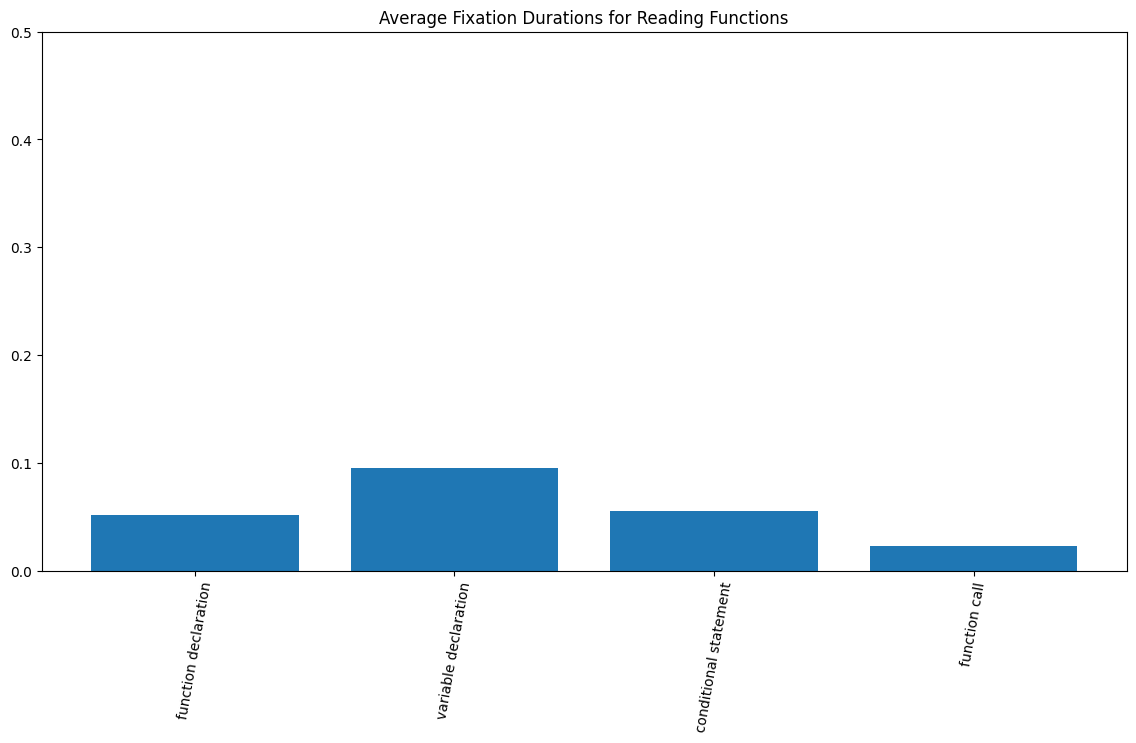

In [46]:
test = [mean(rdur_dict[key]) for key in rdur_dict.keys()]
print(rdur_dict.keys())
print(test)
plt.figure(figsize=(14, 7))
plt.bar(list(rdur_dict.keys()), test)
plt.xticks(rotation=80)
plt.ylim([0, 0.5])
plt.title(f"Average Fixation Durations for Reading Functions")


dict_keys(['function declaration', 'variable declaration', 'conditional statement', 'function call'])
[0.0590805345037411, 0.1361722932618554, 0.07091502653185218, 0.04356728741635936]


Text(0.5, 1.0, 'Average Fixation Durations for Writing Functions')

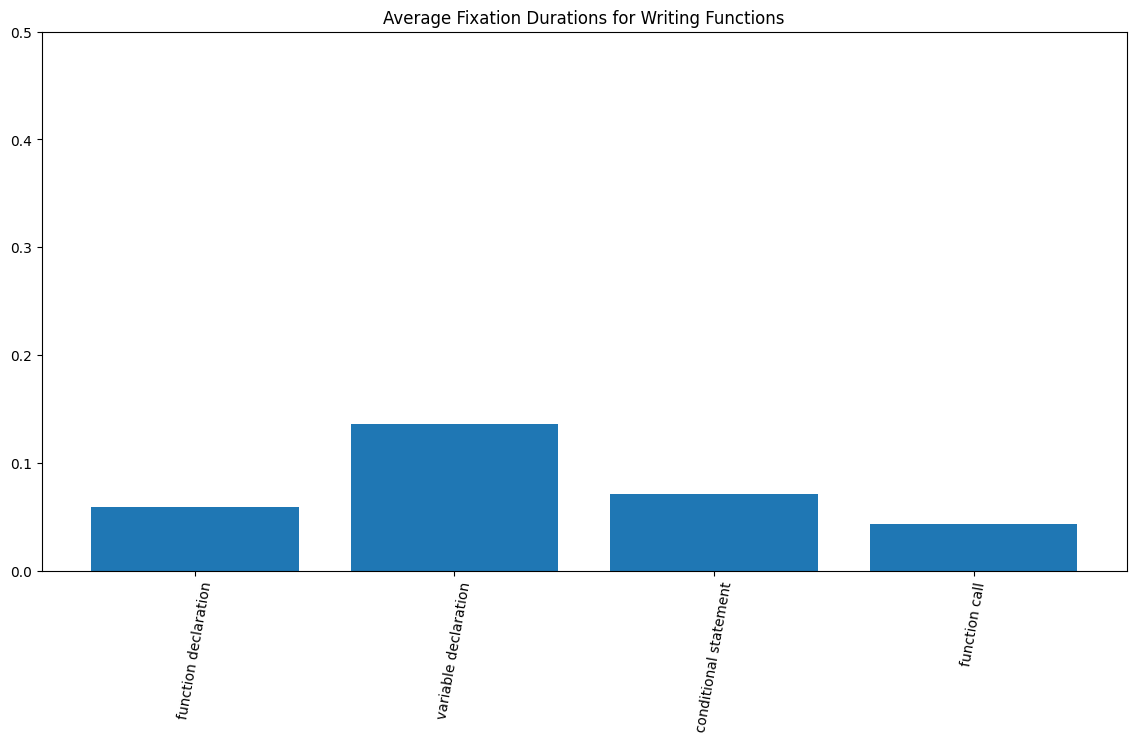

In [47]:
test = [mean(wdur_dict[key]) for key in wdur_dict.keys()]
print(wdur_dict.keys())
print(test)
plt.figure(figsize=(14, 7))
plt.bar(list(wdur_dict.keys()), test)
plt.xticks(rotation=80)
plt.ylim([0, 0.5])
plt.title(f"Average Fixation Durations for Writing Functions")


In [104]:
for k, v in wdur_dict.items():
    print(k, len(wdur_dict[k]), len(rdur_dict[k]))

function declaration 74 82
parameter 74 82
variable declaration 74 82
conditional statement 74 82
function call 74 82
argument 74 82


### Stats

In [42]:
scanpath_pvals = []

for col in dfr.columns:
    rdata = dfr[col]
    wdata = dfw[col]
    rvar = variance(rdata)
    wvar = variance(wdata)
    larger = max(rvar, wvar)
    smaller = min(rvar, wvar)
    ratio = larger/smaller
    test = "Student's"
    equal_var = True
    if ratio >= 4:
        test = "Welch's"
        equal_var = False
    t, p = stats.ttest_ind(a=rdata, b=wdata, equal_var=equal_var)
    scanpath_pvals.append(p)
    # print(f"{key}: Reading: {rvar:.4f} | Writing: {wvar:.4f} | Ratio: {larger/smaller:.4f}")
    print(f"{col} | {test} | Reading: {mean(rdata):.4f} | Writing: {mean(wdata):.4f}| t-value: {t:.4f}, p-value:{p:.4f}")
_, corrected_sppvals, _, _ = smm.multipletests(
    scanpath_pvals, alpha=0.05, method='fdr_bh')
for i, cp in enumerate(corrected_sppvals):
    print(f"{features[i]} : {cp:.4f}")


argument | Student's | Reading: 0.1931 | Writing: 0.1862| t-value: 0.2074, p-value:0.8360
assignment | Student's | Reading: 0.0298 | Writing: 0.0353| t-value: -0.2963, p-value:0.7674
comment | Student's | Reading: 0.0515 | Writing: 0.0893| t-value: -1.4463, p-value:0.1501
conditional_block | Student's | Reading: 0.1549 | Writing: 0.1506| t-value: 0.0942, p-value:0.9250
conditional_statement | Student's | Reading: 0.2277 | Writing: 0.2359| t-value: -0.2525, p-value:0.8010
exception_handling | Student's | Reading: 0.0872 | Writing: 0.1146| t-value: -0.8590, p-value:0.3917
external_class | Student's | Reading: 0.0851 | Writing: 0.0655| t-value: 0.7290, p-value:0.4671
externally_defined_variable_or_function | Student's | Reading: 0.1178 | Writing: 0.1121| t-value: 0.1716, p-value:0.8640
function_call | Student's | Reading: 0.1693 | Writing: 0.1671| t-value: 0.0622, p-value:0.9505
function_declaration | Student's | Reading: 0.2628 | Writing: 0.2512| t-value: 1.3669, p-value:0.1737


KeyError: 'index_operation'

## Expertise Differences in Fixation Counts and Durations

In [69]:
check = [reyf, rnyf, reyd, rnyd,
         rejf, rnjf, rejd, rnjd,
         weyf, wnyf, weyd, wnyd,
         wejf, wnjf, wejd, wnjd]
# for d in check:
#     for k, v in d.items():
#         print(k, len(v))

Fixation Count t-tests
function declaration | Welch's | Group1: 0.0807 | Group2: 0.0821| t-value: -0.0322, p-value:0.9745, effect size:-0.0093
variable declaration | Welch's | Group1: 0.0485 | Group2: 0.1666| t-value: -3.5397, p-value:0.0009, effect size:-0.7685
conditional statement | Welch's | Group1: 0.0437 | Group2: 0.1108| t-value: -2.4406, p-value:0.0179, effect size:-0.5374
conditional block | Student's | Group1: 0.0886 | Group2: 0.1916| t-value: -1.6891, p-value:0.0961, effect size:-0.4277
function call | Student's | Group1: 0.0577 | Group2: 0.0994| t-value: -1.1801, p-value:0.2424, effect size:-0.2988

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0276 | Group2: 0.0591| t-value: -2.8582, p-value:0.0058, effect size:-0.7237
variable declaration | Student's | Group1: 0.0408 | Group2: 0.0934| t-value: -2.3801, p-value:0.0203, effect size:-0.6026
conditional statement | Student's | Group1: 0.0437 | Group2: 0.0807| t-value: -1.9913, p-value:0.0508, effect s

In [264]:
# _, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
# print("Fixation Count Corrected P-values")
# for i, cp in enumerate(corrected_fix_pvals):
#     print(f"{fix_features[i]} : {cp:.4f}")

# _, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
# print("\n\nFixation Duration Corrected P-values")
# for i, cp in enumerate(corrected_dur_pvals):
#     print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.9745
variable declaration : 0.0043
conditional statement : 0.0447
conditional block : 0.1602
function call : 0.3030


Fixation Duration Corrected P-values
function declaration : 0.0288
variable declaration : 0.0509
conditional statement : 0.0635
conditional block : 0.0627
function call : 0.1903


In [265]:
# # TODO compare all reading with all writing for java experience
# fexperts = {k: rejf[k] + wejf[k] for k, v in rejf.items() if k in wejf.keys()}
# fnovices = {k: rnjf[k] + wnjf[k] for k, v in rnjf.items() if k in wnjf.keys()}
# print("Fixation Count t-tests")
# fixation_pvals, fix_features = my_t_test(fexperts, fnovices)

# dexperts = {k: rejd[k] + wejd[k] for k, v in rejd.items() if k in wejd.keys()}
# dnovices = {k: rnjd[k] + wnjd[k] for k, v in rnjd.items() if k in wnjd.keys()}
# print("\nFixation Duration t-tests")
# duration_pvals, dur_features = my_t_test(dexperts, dnovices)


Fixation Count t-tests
function declaration | Welch's | Group1: 0.1028 | Group2: 0.0690| t-value: 0.7626, p-value:0.4519, effect size:0.2335
variable declaration | Student's | Group1: 0.0819 | Group2: 0.1413| t-value: -1.4269, p-value:0.1586, effect size:-0.3667
conditional statement | Student's | Group1: 0.0686 | Group2: 0.0930| t-value: -0.7363, p-value:0.4643, effect size:-0.1892
conditional block | Student's | Group1: 0.1105 | Group2: 0.1737| t-value: -1.0079, p-value:0.3174, effect size:-0.2590
function call | Student's | Group1: 0.0633 | Group2: 0.0941| t-value: -0.8534, p-value:0.3967, effect size:-0.2193

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0443 | Group2: 0.0477| t-value: -0.2860, p-value:0.7758, effect size:-0.0735
variable declaration | Student's | Group1: 0.0590 | Group2: 0.0802| t-value: -0.9147, p-value:0.3638, effect size:-0.2351
conditional statement | Student's | Group1: 0.0564 | Group2: 0.0714| t-value: -0.7758, p-value:0.4408, effect

In [266]:
# _, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
# print("Fixation Count Corrected P-values")
# for i, cp in enumerate(corrected_fix_pvals):
#     print(f"{fix_features[i]} : {cp:.4f}")

# _, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
# print("\n\nFixation Duration Corrected P-values")
# for i, cp in enumerate(corrected_dur_pvals):
#     print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.4643
variable declaration : 0.4643
conditional statement : 0.4643
conditional block : 0.4643
function call : 0.4643


Fixation Duration Corrected P-values
function declaration : 0.7758
variable declaration : 0.7277
conditional statement : 0.7277
conditional block : 0.7277
function call : 0.7277


In [57]:
#TODO compare experts to novices on reading tasks for years of experience
print("Fixation Count t-tests")
fixation_pvals, fix_features = my_t_test("experts", "novices", reyf, rnyf, "reading_experts_vs_novices_fc.csv")
print("\nFixation Duration t-tests")
duration_pvals, dur_features = my_t_test("experts", "novices", reyd, rnyd, "reading_experts_vs_novices_fd.csv")


Fixation Count t-tests
function declaration | Student's | Group1: 0.0666 | Group2: 0.1310| t-value: -1.5352, p-value:0.1297, effect size:-0.3966
variable declaration | Student's | Group1: 0.0548 | Group2: 0.1858| t-value: -4.1726, p-value:0.0001, effect size:-1.0779
conditional statement | Welch's | Group1: 0.0268 | Group2: 0.1209| t-value: -3.2391, p-value:0.0034, effect size:-1.0650
function call | Student's | Group1: 0.0143 | Group2: 0.0518| t-value: -2.6101, p-value:0.0113, effect size:-0.6743

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0297 | Group2: 0.0653| t-value: -3.0791, p-value:0.0031, effect size:-0.7954
variable declaration | Student's | Group1: 0.0518 | Group2: 0.1132| t-value: -2.5523, p-value:0.0131, effect size:-0.6593
conditional statement | Student's | Group1: 0.0258 | Group2: 0.0881| t-value: -4.0530, p-value:0.0001, effect size:-1.0470
function call | Welch's | Group1: 0.0090 | Group2: 0.0498| t-value: -3.5049, p-value:0.0017, effect siz

In [268]:
_, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
print("Fixation Count Corrected P-values")
for i, cp in enumerate(corrected_fix_pvals):
    print(f"{fix_features[i]} : {cp:.4f}")

_, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
print("\n\nFixation Duration Corrected P-values")
for i, cp in enumerate(corrected_dur_pvals):
    print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.8528
variable declaration : 0.0116
conditional statement : 0.0467
conditional block : 0.0467
function call : 0.2624


Fixation Duration Corrected P-values
function declaration : 0.0184
variable declaration : 0.0184
conditional statement : 0.0659
conditional block : 0.0184
function call : 0.0190


In [269]:
# TODO compare experts to novices on reading tasks for java experience
print("Fixation Count t-tests")
fixation_pvals, fix_features = my_t_test(rejf, rnjf)
print("\nFixation Duration t-tests")
duration_pvals, dur_features = my_t_test(rejd, rnjd)


Fixation Count t-tests
function declaration | Welch's | Group1: 0.1157 | Group2: 0.0629| t-value: 0.9081, p-value:0.3738, effect size:0.3168
variable declaration | Student's | Group1: 0.0868 | Group2: 0.0923| t-value: -0.1591, p-value:0.8743, effect size:-0.0484
conditional statement | Student's | Group1: 0.0647 | Group2: 0.0746| t-value: -0.2851, p-value:0.7769, effect size:-0.0868
conditional block | Student's | Group1: 0.0967 | Group2: 0.1157| t-value: -0.3249, p-value:0.7468, effect size:-0.0989
function call | Student's | Group1: 0.0533 | Group2: 0.0467| t-value: 0.2581, p-value:0.7976, effect size:0.0785

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0408 | Group2: 0.0439| t-value: -0.2142, p-value:0.8314, effect size:-0.0652
variable declaration | Student's | Group1: 0.0489 | Group2: 0.0360| t-value: 0.9203, p-value:0.3626, effect size:0.2800
conditional statement | Student's | Group1: 0.0501 | Group2: 0.0497| t-value: 0.0263, p-value:0.9791, effect size

In [270]:
_, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
print("Fixation Count Corrected P-values")
for i, cp in enumerate(corrected_fix_pvals):
    print(f"{fix_features[i]} : {cp:.4f}")

_, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
print("\n\nFixation Duration Corrected P-values")
for i, cp in enumerate(corrected_dur_pvals):
    print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.8743
variable declaration : 0.8743
conditional statement : 0.8743
conditional block : 0.8743
function call : 0.8743


Fixation Duration Corrected P-values
function declaration : 0.9791
variable declaration : 0.9791
conditional statement : 0.9791
conditional block : 0.9791
function call : 0.9791


In [271]:
# TODO compare experts to novices on writing tasks for years of experience
print("Fixation Count t-tests")
fixation_pvals, fix_features = my_t_test(weyf, wnyf)
print("\nFixation Duration t-tests")
duration_pvals, dur_features = my_t_test(weyd, wnyd)


Fixation Count t-tests
function declaration | Student's | Group1: 0.0551 | Group2: 0.0870| t-value: -0.8692, p-value:0.3962, effect size:-0.4075
variable declaration | Welch's | Group1: 0.0940 | Group2: 0.2341| t-value: -1.7722, p-value:0.0982, effect size:-0.6204
conditional statement | Student's | Group1: 0.0802 | Group2: 0.1323| t-value: -0.6993, p-value:0.4933, effect size:-0.3278
conditional block | Student's | Group1: 0.2118 | Group2: 0.2638| t-value: -0.3378, p-value:0.7394, effect size:-0.1584
function call | Welch's | Group1: 0.1303 | Group2: 0.1727| t-value: -0.5504, p-value:0.5892, effect size:-0.2044

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0454 | Group2: 0.0603| t-value: -0.7640, p-value:0.4547, effect size:-0.3582
variable declaration | Welch's | Group1: 0.0996 | Group2: 0.1658| t-value: -1.4387, p-value:0.1678, effect size:-0.5443
conditional statement | Student's | Group1: 0.0758 | Group2: 0.1160| t-value: -0.8664, p-value:0.3977, effect s

In [272]:
_, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
print("Fixation Count Corrected P-values")
for i, cp in enumerate(corrected_fix_pvals):
    print(f"{fix_features[i]} : {cp:.4f}")

_, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
print("\n\nFixation Duration Corrected P-values")
for i, cp in enumerate(corrected_dur_pvals):
    print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.7365
variable declaration : 0.4908
conditional statement : 0.7365
conditional block : 0.7394
function call : 0.7365


Fixation Duration Corrected P-values
function declaration : 0.5684
variable declaration : 0.4312
conditional statement : 0.5684
conditional block : 0.7853
function call : 0.4312


In [273]:
# TODO compare experts to novices on writing tasks for java experiences
print("Fixation Count t-tests")
fixation_pvals, fix_features = my_t_test(wejf, wnjf)
print("\nFixation Duration t-tests")
duration_pvals, dur_features = my_t_test(wejd, wnjd)


Fixation Count t-tests
function declaration | Student's | Group1: 0.0643 | Group2: 0.0808| t-value: -0.4252, p-value:0.6758, effect size:-0.2075
variable declaration | Welch's | Group1: 0.0673 | Group2: 0.2356| t-value: -2.3460, p-value:0.0336, effect size:-0.7575
conditional statement | Student's | Group1: 0.0804 | Group2: 0.1284| t-value: -0.6182, p-value:0.5442, effect size:-0.3017
conditional block | Student's | Group1: 0.1520 | Group2: 0.2857| t-value: -0.8472, p-value:0.4080, effect size:-0.4134
function call | Welch's | Group1: 0.0936 | Group2: 0.1855| t-value: -1.2942, p-value:0.2122, effect size:-0.4508

Fixation Duration t-tests
function declaration | Student's | Group1: 0.0550 | Group2: 0.0551| t-value: -0.0035, p-value:0.9973, effect size:-0.0017
variable declaration | Student's | Group1: 0.0893 | Group2: 0.1655| t-value: -1.2940, p-value:0.2120, effect size:-0.6314
conditional statement | Student's | Group1: 0.0753 | Group2: 0.1134| t-value: -0.7867, p-value:0.4417, effect

In [274]:
_, corrected_fix_pvals, _, _ = smm.multipletests(fixation_pvals, alpha=0.05, method='fdr_bh')
print("Fixation Count Corrected P-values")
for i, cp in enumerate(corrected_fix_pvals):
    print(f"{fix_features[i]} : {cp:.4f}")

_, corrected_dur_pvals, _, _ = smm.multipletests(duration_pvals, alpha=0.05, method='fdr_bh')
print("\n\nFixation Duration Corrected P-values")
for i, cp in enumerate(corrected_dur_pvals):
    print(f"{dur_features[i]} : {cp:.4f}")

Fixation Count Corrected P-values
function declaration : 0.6758
variable declaration : 0.1678
conditional statement : 0.6758
conditional block : 0.6758
function call : 0.5305


Fixation Duration Corrected P-values
function declaration : 0.9973
variable declaration : 0.5784
conditional statement : 0.5784
conditional block : 0.5784
function call : 0.5784


# Take 2

In [79]:
import os
import math
import numpy as np
import pandas as pd
from statistics import mean, variance
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn import preprocessing
import statsmodels.stats.multitest as smm


In [64]:
fix_rfiles = os.listdir("abstract_fixation_counts/reading")
fix_wfiles = os.listdir("abstract_fixation_counts/writing")
dur_rfiles = os.listdir("abstract_fixation_durations/reading")
dur_wfiles = os.listdir("abstract_fixation_durations/writing")

rfix_dict, rdur_dict = collect_fixations(fix_rfiles, 'reading')
wfix_dict, wdur_dict = collect_fixations(fix_wfiles, 'writing')

89 ['process.csv', 'getOkCommand18.csv', 'setSelectedScript.csv', 'openNewContainerWindow.csv', 'getRelFeedItems.csv', 'testGetClassification.csv', 'getCollaborateCollection.csv', 'capitalizeString.csv', 'createServerChooser.csv', 'loadSystems.csv', 'doOutput.csv', 'addRelativeHeaders.csv', 'genSql.csv', 'checkDescendantM.csv', 'jbInit.csv', 'makeCenter.csv', 'createDataset.csv', 'addLimit.csv', 'iconify.csv', 'resolveValue.csv', 'modifyRoleInCache.csv', 'close.csv', 'getMessage.csv', 'exit.csv', 'moveUpTarget.csv', 'show.csv', 'resetSchedConflict.csv', 'countQuery.csv', 'removeSelection.csv', 'joinTableRender.csv', 'iamNear.csv', 'connectionErrorOccurred.csv', 'initOptionsMenu.csv', 'load.csv', 'tellAgain.csv', 'init2.csv', 'openCursor.csv', 'getAll.csv', 'readResponse.csv', 'print.csv', 'actionLoadNotes.csv', 'removeRedundantOperations.csv', 'encode.csv', 'fScore.csv', 'getFastestGenerator.csv', 'addDbArgs.csv', 'addToTechnicalComment.csv', 'testSetEvtID.csv', 'testSetChkEvtID.csv', 

In [19]:
print("fixations distribution:", shapiro(list(avg_rfixdict.values())))
print("durations distribution:", shapiro(list(avg_rdurdict.values())))

fixations distribution: ShapiroResult(statistic=0.8980512619018555, pvalue=0.016642721369862556)
durations distribution: ShapiroResult(statistic=0.8909307718276978, pvalue=0.011706260964274406)


Text(0.5, 1.0, 'Average Fixation Counts for Reading Functions')

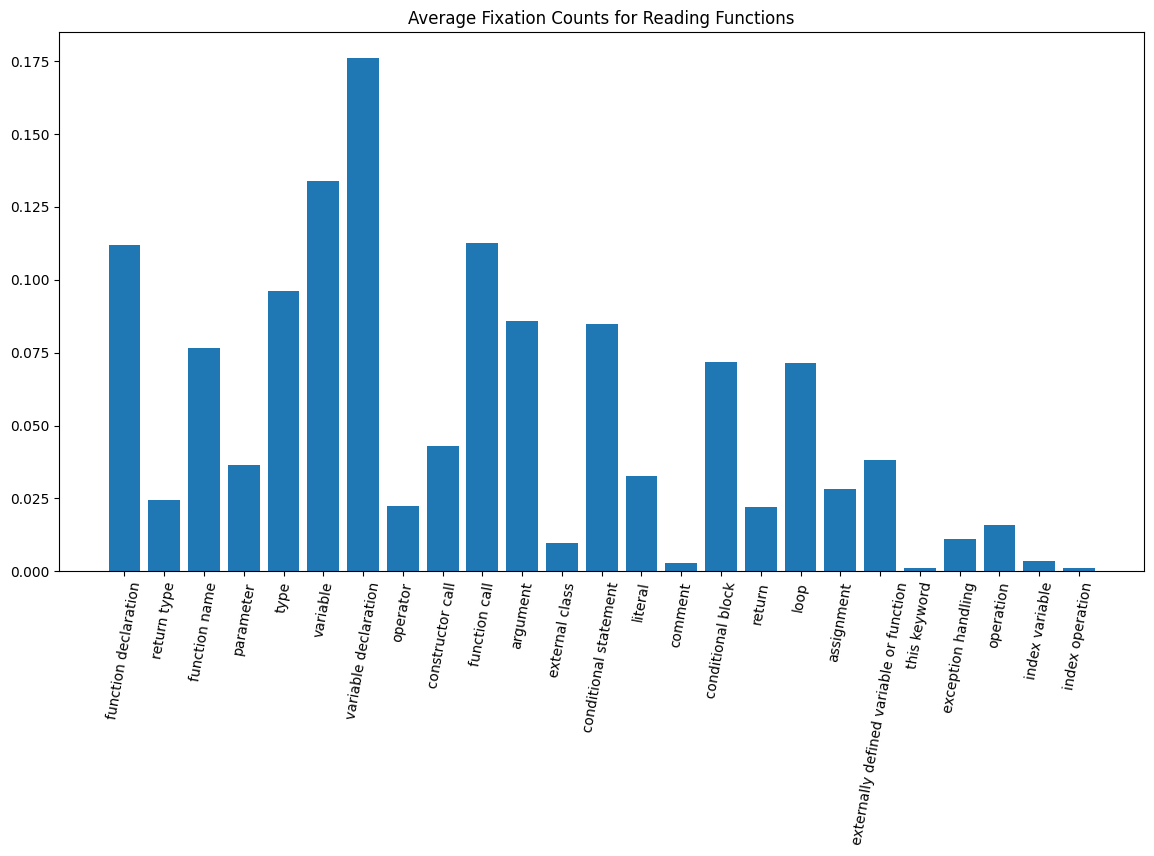

In [20]:
plt.figure(figsize=(14, 7))
plt.bar(list(avg_rfixdict.keys()), list(avg_rfixdict.values()))
plt.xticks(rotation=80)
plt.title(f"Average Fixation Counts for Reading Functions")

Text(0.5, 1.0, 'Average Fixation Durations for Reading Functions')

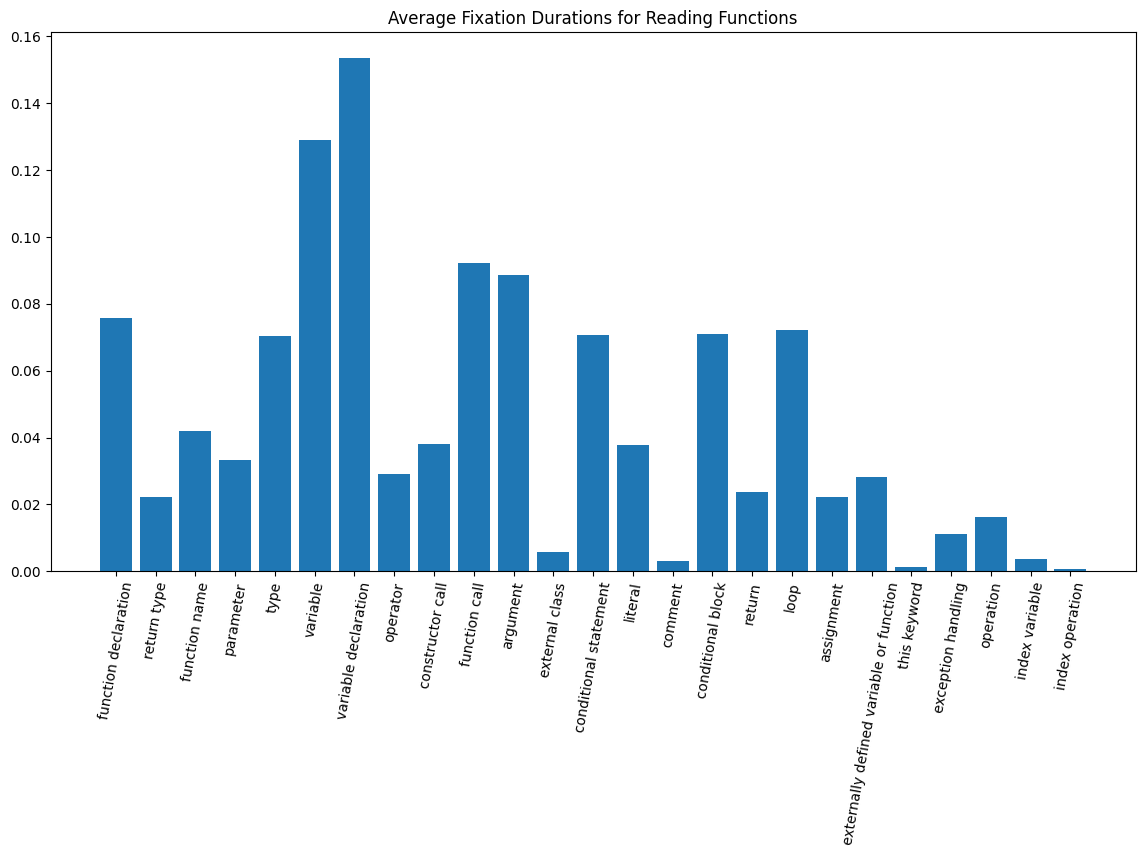

In [8]:
plt.figure(figsize=(14, 7))
plt.bar(list(avg_rdurdict.keys()), list(avg_rdurdict.values()))
plt.xticks(rotation=80)
plt.title(f"Average Fixation Durations for Reading Functions")


In [22]:
print("fixations distribution:", shapiro(list(avg_wfixdict.values())))
print("durations distribution:", shapiro(list(avg_wdurdict.values())))


fixations distribution: ShapiroResult(statistic=0.8998013734817505, pvalue=0.018164537847042084)
durations distribution: ShapiroResult(statistic=0.8941667079925537, pvalue=0.013724674470722675)


Text(0.5, 1.0, 'Average Fixation Counts for Writing Functions')

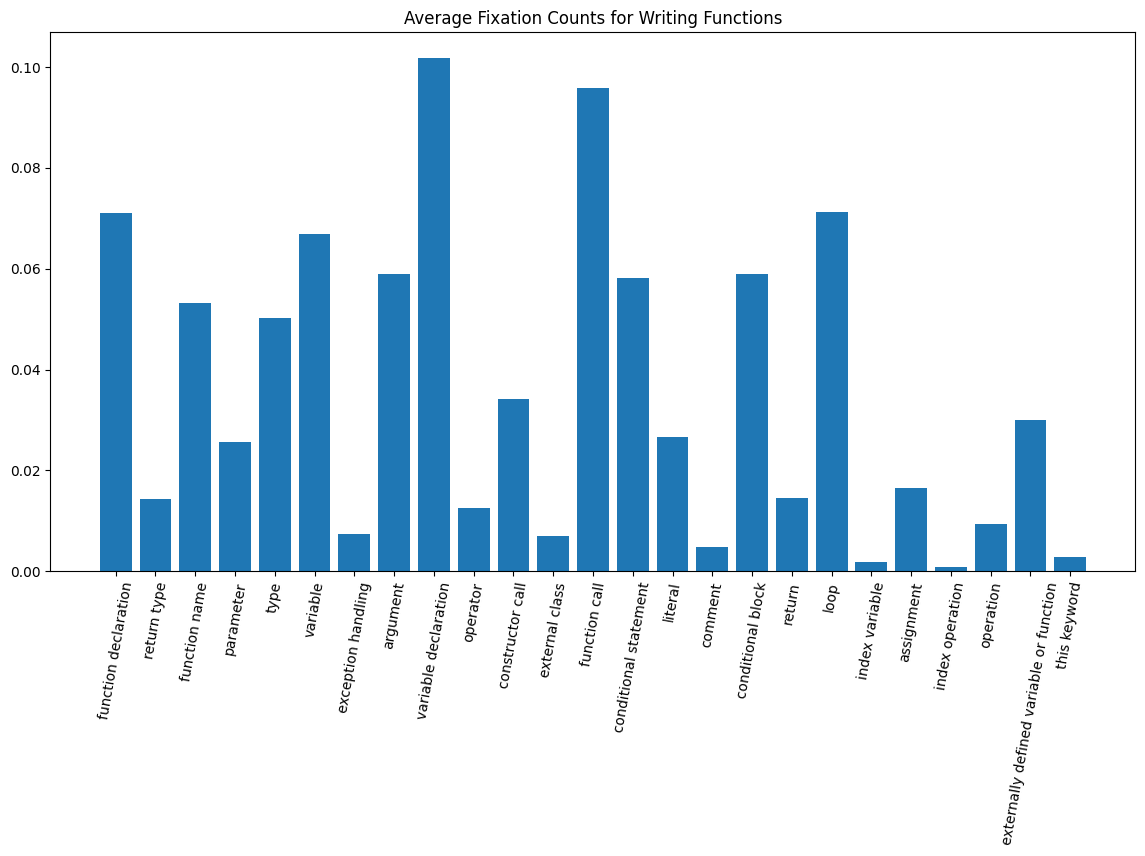

In [23]:
plt.figure(figsize=(14, 7))
plt.bar(list(avg_wfixdict.keys()), list(avg_wfixdict.values()))
plt.xticks(rotation=80)
plt.title(f"Average Fixation Counts for Writing Functions")


Text(0.5, 1.0, 'Average Fixation Durations for Writing Functions')

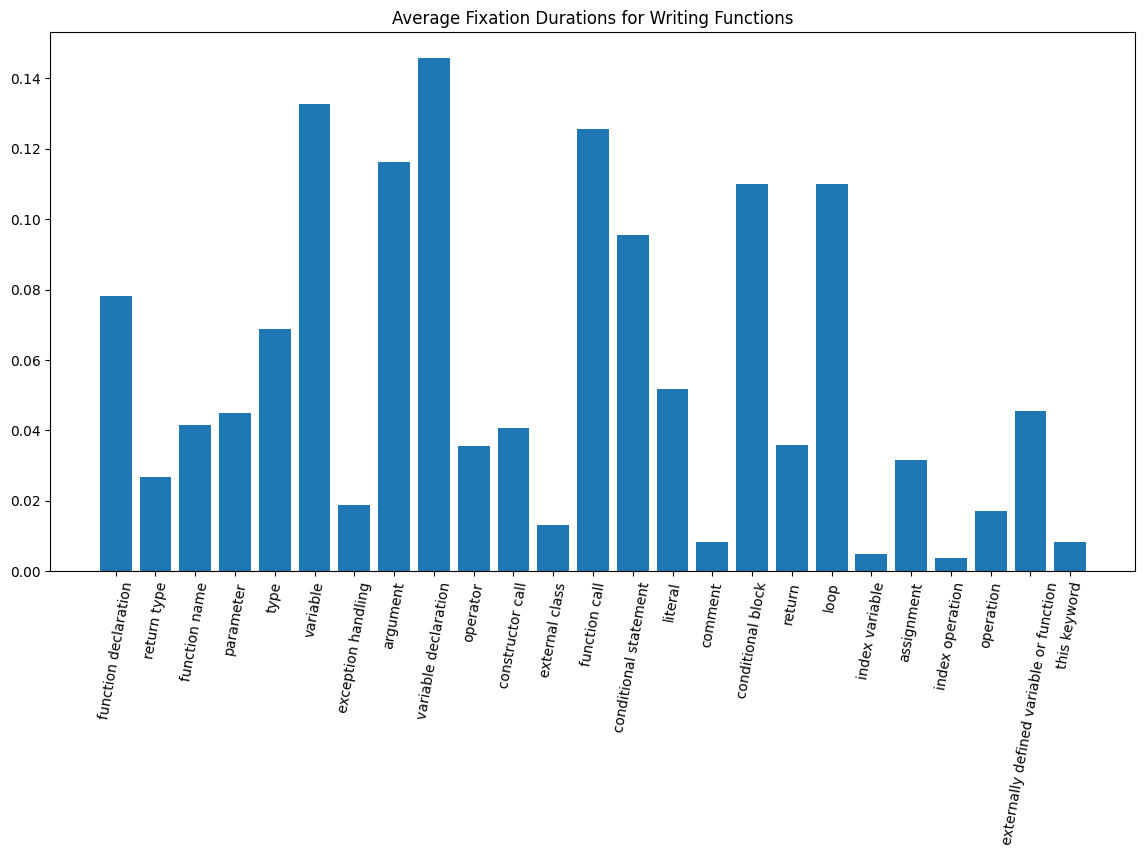

In [24]:
plt.figure(figsize=(14, 7))
plt.bar(list(avg_wdurdict.keys()), list(avg_wdurdict.values()))
plt.xticks(rotation=80)
plt.title(f"Average Fixation Durations for Writing Functions")

# T - tests

In [49]:
# rfixdict, rdurdict, wfixdict, wdurdict
# sort by keys
sorted_keys = list(rfixdict.keys())
sorted_keys.sort()

sorted_rfix = {key : rfixdict[key] for key in sorted_keys}
sorted_rdur = {key : rdurdict[key] for key in sorted_keys}
sorted_wfix = {key : wfixdict[key] for key in sorted_keys}
sorted_wdur = {key : wdurdict[key] for key in sorted_keys}


In [50]:
print(sorted_rdur)

{'argument': [0.12454614578812125, 0.01874480620794751, 0.04946332761844705, 0.07179307854944023, 0.03213298955050934, 0.057084824210309686, 0.06726056007905357, 0.099624331609558, 0.13938732222393085, 0.0, 0.11305863236479756, 0.11107585545767003, 0.01683083152851286, 0.0, 0.3352755908509059, 0.2713007781142054, 0.017181380122047868, 0.21867519859438442, 0.16569748691028022, 0.02811589726500422, 0.01312114879153048, 0.049115210874568806, 0.015851783402082164, 0.020305467640507217, 0.3872335947374043, 0.06783084850614589, 0.0, 0.018743181786571254, 0.11410054021610135, 0.014828384767857392, 0.10174861442594502, 0.1342956070968813, 0.2119891823186038, 0.06654158788870225, 0.23251808123074483, 0.0590292761019963, 0.05015959586409145, 0.04402773262485114, 0.010691044714759719, 0.010974638638157177, 0.06539447255251278, 0.04323547053921777, 0.0069421042950429755, 0.008331191587325175, 0.3584731293364006, 0.10596577945085411, 0.016401330565692433, 0.020825771422246904, 0.346396906933815, 0.

## Fixation Count

In [71]:
fpvals = []
for key in sorted_keys:
    rdata = sorted_rfix[key]
    wdata = sorted_wfix[key]
    rvar = variance(rdata)
    wvar = variance(wdata)
    larger = max(rvar, wvar)
    smaller = min(rvar, wvar)
    ratio = larger/smaller
    test = "Student's"
    equal_var = True
    if ratio >= 4:
        test = "Welch's"
        equal_var = False
    t, p = stats.ttest_ind(a=rdata, b=wdata, equal_var=equal_var)
    fpvals.append(p)
    # print(f"{key}: Reading: {rvar:.4f} | Writing: {wvar:.4f} | Ratio: {larger/smaller:.4f}")
    print(f"{key} | {test} | Reading: {mean(rdata):.4f} | Writing: {mean(wdata):.4f}| t-value: {t:.4f}, p-value:{p:.4f}")



argument | Student's | Reading: 0.0890 | Writing: 0.0648| t-value: 1.5278, p-value:0.1287
assignment | Welch's | Reading: 0.1326 | Writing: 0.0552| t-value: 2.9069, p-value:0.0075
comment | Student's | Reading: 0.0114 | Writing: 0.0159| t-value: -0.6385, p-value:0.5269
conditional block | Student's | Reading: 0.1422 | Writing: 0.1128| t-value: 1.0991, p-value:0.2751
conditional statement | Student's | Reading: 0.1426 | Writing: 0.0929| t-value: 2.1402, p-value:0.0350
constructor call | Student's | Reading: 0.0738 | Writing: 0.0603| t-value: 0.9502, p-value:0.3446
exception handling | Welch's | Reading: 0.0406 | Writing: 0.0199| t-value: 2.2368, p-value:0.0326
external class | Student's | Reading: 0.0358 | Writing: 0.0297| t-value: 0.5237, p-value:0.6035
externally defined variable or function | Welch's | Reading: 0.1061 | Writing: 0.0803| t-value: 0.9747, p-value:0.3347
function call | Student's | Reading: 0.1209 | Writing: 0.1052| t-value: 0.9778, p-value:0.3298
function declaration |

In [72]:
_,corrected_fpvals,_,_ = smm.multipletests(fpvals, alpha=0.05, method='fdr_bh')

In [73]:
for i, cp in enumerate(corrected_fpvals):
    print(f"{sorted_keys[i]} : {cp:.4f}")

argument : 0.2515
assignment : 0.0270
comment : 0.5988
conditional block : 0.4308
conditional statement : 0.0874
constructor call : 0.4308
exception handling : 0.0874
external class : 0.6560
externally defined variable or function : 0.4308
function call : 0.4308
function declaration : 0.0010
function name : 0.0242
index operation : 0.4308
index variable : 0.2515
literal : 0.5162
loop : 0.9757
operation : 0.4308
operator : 0.0392
parameter : 0.2515
return : 0.4308
return type : 0.0001
this keyword : 0.9757
type : 0.0043
variable : 0.0034
variable declaration : 0.0242


## Fixation Duration

In [74]:
dpvals = []
for key in sorted_keys:
    rdata = sorted_rdur[key]
    wdata = sorted_wdur[key]
    rvar = variance(rdata)
    wvar = variance(wdata)
    larger = max(rvar, wvar)
    smaller = min(rvar, wvar)
    ratio = larger/smaller
    test = "Student's"
    equal_var = True
    if ratio >= 4:
        test = "Welch's"
        equal_var = False
    t, p = stats.ttest_ind(a=rdata, b=wdata, equal_var=equal_var)
    dpvals.append(p)
    # print(f"{key}: Reading: {rvar:.4f} | Writing: {wvar:.4f} | Ratio: {larger/smaller:.4f}")
    print(f"{key} | {test} | Reading: {mean(rdata):.4f} | Writing: {mean(wdata):.4f}| t-value: {t:.4f}, p-value:{p:.4f}")


argument | Student's | Reading: 0.0917 | Writing: 0.1276| t-value: -2.0187, p-value:0.0454
assignment | Student's | Reading: 0.1043 | Writing: 0.1057| t-value: -0.0559, p-value:0.9557
comment | Student's | Reading: 0.0133 | Writing: 0.0280| t-value: -1.7200, p-value:0.0934
conditional block | Student's | Reading: 0.1401 | Writing: 0.2104| t-value: -2.1477, p-value:0.0348
conditional statement | Student's | Reading: 0.1185 | Writing: 0.1526| t-value: -1.5623, p-value:0.1216
constructor call | Student's | Reading: 0.0651 | Writing: 0.0719| t-value: -0.5568, p-value:0.5790
exception handling | Student's | Reading: 0.0409 | Writing: 0.0505| t-value: -0.8679, p-value:0.3899
external class | Welch's | Reading: 0.0211 | Writing: 0.0553| t-value: -2.3437, p-value:0.0319
externally defined variable or function | Student's | Reading: 0.0786 | Writing: 0.1219| t-value: -1.7388, p-value:0.0877
function call | Student's | Reading: 0.0990 | Writing: 0.1381| t-value: -2.8891, p-value:0.0045
function 

In [75]:
_,corrected_dpvals,_,_ = smm.multipletests(dpvals, alpha=0.05, method='fdr_bh')


In [76]:
for i, cp in enumerate(corrected_dpvals):
    print(f"{sorted_keys[i]} : {cp:.4f}")


argument : 0.1599
assignment : 0.9557
comment : 0.2334
conditional block : 0.1599
conditional statement : 0.2339
constructor call : 0.7236
exception handling : 0.6092
external class : 0.1599
externally defined variable or function : 0.2334
function call : 0.0559
function declaration : 0.7236
function name : 0.9258
index operation : 0.3591
index variable : 0.6905
literal : 0.3549
loop : 0.1599
operation : 0.6905
operator : 0.2339
parameter : 0.0259
return : 0.1599
return type : 0.2339
this keyword : 0.1599
type : 0.8137
variable : 0.6641
variable declaration : 0.9258


# Take 1

In [149]:
# remove outliers?
##### reading
#############
# filename = "capitalizeString"
# filename = "addLimit"
# filename = "Value"
# filename = "testLogin"
# filename = "refreshTreePanel"
# filename = "modifyRoleInCache"
# filename = "getInstitutions"
# filename = "actionLoadNotes"
# filename = "getMessage"
# filename = "close"

##### writing
#############
# filename = "actionPerformed"
# filename = "addPKColumn"
# filename = "equals"
# filename = "getUserNameFromCookie"
# filename = "updateSchema"
# filename = "getImageWithSource"
# filename = "add"
# filename = "show"
filename = "go"
# filename = "BFSdist"

In [150]:
# reading in file for fixation and duration
dur = pd.read_csv(f"fixation_durations/{filename}_fd.csv")
fix = pd.read_csv(f"fixation_counts/{filename}_fc.csv")

# getting just the bounding boxes
dur = dur.iloc[:, 1:-6]
fix = fix.iloc[:, 1:-6]


# getting all fixations on the tokens for all participants
# and all durations
dur_sums = dur.sum()
fix_sums = fix.sum()
dur_total = sum(dur_sums)
fix_total = sum(fix_sums)

# getting the percentage breakdown of which tokens participants look at
dur_ratio = {}
for i, num in enumerate(dur_sums):
    dur_ratio[dur_sums.index[i]] = (num/dur_total)*100

fix_ratio = {}
for i, num in enumerate(fix_sums):
    fix_ratio[fix_sums.index[i]] = (num/fix_total)*100
    
# putting token fixations and durations into their own respective dictionaries    
durdict = dict(sorted(dur_ratio.items(), key=lambda item: item[1]))
fixdict = dict(sorted(fix_ratio.items(), key=lambda item: item[1]))


Text(0.5, 1.0, "Duration Percentages for 'go' function")

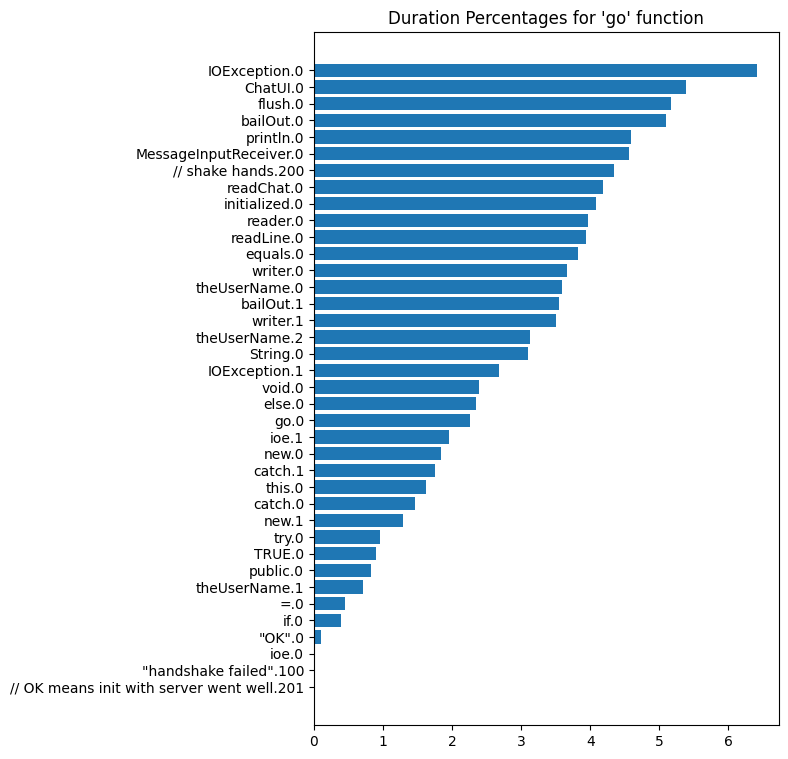

In [151]:
plt.figure(figsize=(6,9))
plt.barh(list(durdict.keys()), list(durdict.values()))
plt.title(f"Duration Percentages for '{filename}' function")

Text(0.5, 1.0, "Fixation Percentages for 'go' function")

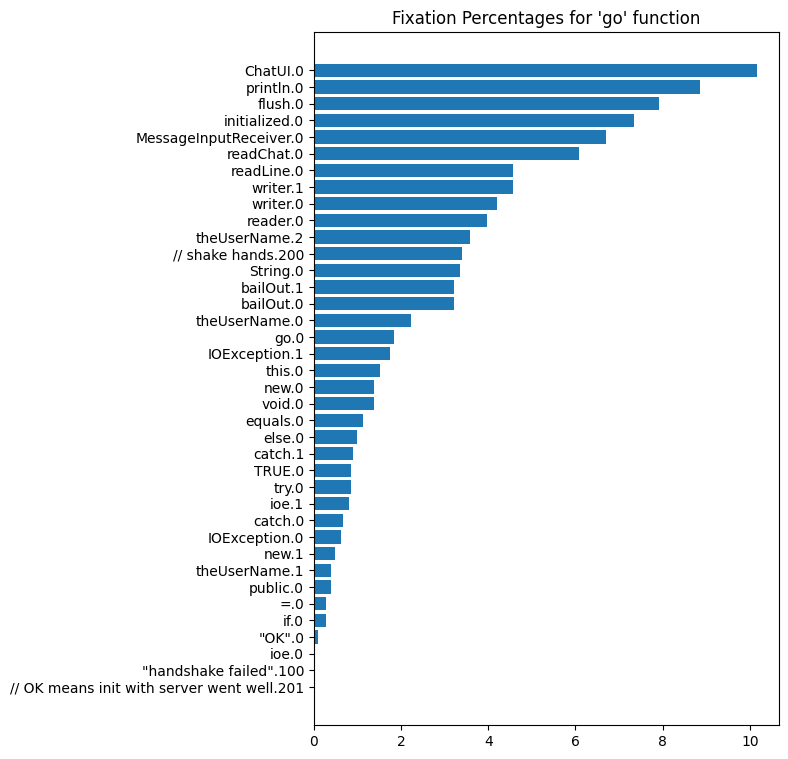

In [152]:
plt.figure(figsize=(6, 9))
plt.barh(list(fixdict.keys()), list(fixdict.values()))
plt.title(f"Fixation Percentages for '{filename}' function")
